In [1]:
%%capture
%run full_setup.py

In [2]:
from tfidf_corpus_dictionary import get_tfidf_tokendocs_corpus_dict
from gensim.models import LdaModel, LsiModel, CoherenceModel
from sklearn.decomposition import NMF, PCA
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
tfidf_matrix, feature_names, tokenized_docs, corpus, dictionary = get_tfidf_tokendocs_corpus_dict(df, max_df=0.5, min_df=5, max_features=1000)

In [15]:
from coherence_by_topics import coherence_by_topics
from coherence_by_words import coherence_by_words

In [16]:
topics = [5, 10, 20, 50]

In [17]:
evaluation_by_topics = {}

for n_topics in topics:
    metrics_words = coherence_by_topics(n = n_topics, corpus=corpus, dictionary=dictionary,
                               texts=tokenized_docs, feature_names=feature_names, tfidf=tfidf_matrix)
    
    evaluation_by_topics[n_topics] = metrics_words

In [18]:
evaluation_by_topics[5]

[('LDA', 0.4505),
 ('LSA', 0.4028),
 ('NMF', 0.6861),
 ('PCA', 0.4724),
 ('RP', 0.219)]

In [19]:
evaluation_by_topics[10]

[('LDA', 0.4327),
 ('LSA', 0.3684),
 ('NMF', 0.6761),
 ('PCA', 0.4148),
 ('RP', 0.2127)]

In [20]:
evaluation_by_topics[20]

[('LDA', 0.402),
 ('LSA', 0.3546),
 ('NMF', 0.6258),
 ('PCA', 0.3384),
 ('RP', 0.2095)]

In [21]:
evaluation_by_topics[50]

[('LDA', 0.3503),
 ('LSA', 0.3283),
 ('NMF', 0.5271),
 ('PCA', 0.3126),
 ('RP', 0.2034)]

In [22]:
words = [10, 100, 1000, 10000]

In [23]:
evaluation_by_words = {}

for n_words in words:
    metrics_words = coherence_by_words(df, n = n_words)
    evaluation_by_words[n_words] = metrics_words

In [24]:
evaluation_by_words[10]

[('LDA', 0.4636),
 ('LSA', 0.4636),
 ('NMF', 0.4636),
 ('PCA', 0.4636),
 ('RP', 0.4636)]

In [25]:
evaluation_by_words[100]

[('LDA', 0.4312),
 ('LSA', 0.4129),
 ('NMF', 0.4591),
 ('PCA', 0.3411),
 ('RP', 0.4035)]

In [26]:
evaluation_by_words[1000]

[('LDA', 0.4505),
 ('LSA', 0.4028),
 ('NMF', 0.6861),
 ('PCA', 0.4724),
 ('RP', 0.219)]

In [27]:
evaluation_by_words[10000]

[('LDA', 0.5758),
 ('LSA', 0.6189),
 ('NMF', 0.7256),
 ('PCA', 0.6201),
 ('RP', 0.6917)]

In [31]:
def plots(evaluation, type: str):
    for n, metrics in evaluation.items():
        model_names, coherence_values = zip(*metrics)

        # Create a DataFrame for easy plotting with Seaborn
        data = {'Model': model_names, 'Coherence Value': coherence_values}
        df = pd.DataFrame(data)

        plt.figure(figsize=(8, 5))
        
        # Use Seaborn's barplot with the hue parameter
        sns.barplot(x='Model', y='Coherence Value', data=df, hue='Model', palette='viridis')
        
        plt.xlabel('Model')
        plt.ylabel('Coherence Value')
        plt.title(f'Coherence Evaluation for {n} {type}')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        
        figures_folder = R'C:\Users\andre\OneDrive - Alma Mater Studiorum Università di Bologna\University\UniBo\Machine Learning\PR1.20\figures'
        save_path = os.path.join(figures_folder, f'coherence_evaluation_{n}_{type}')
        
        plt.savefig(save_path)
        plt.show()

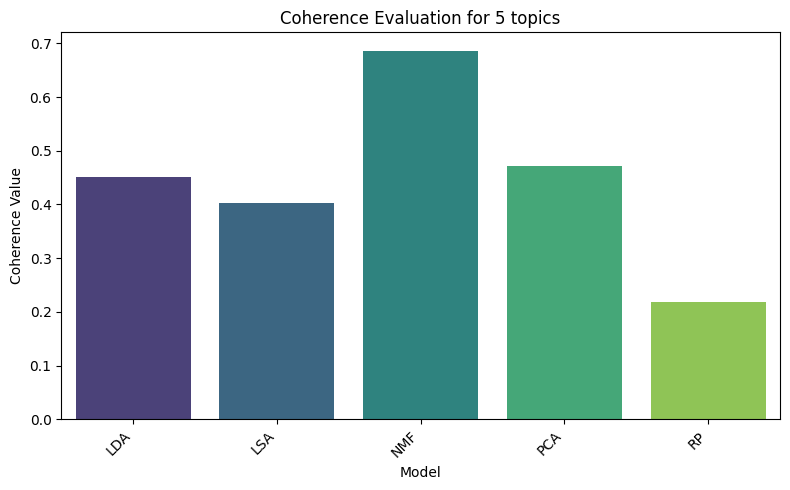

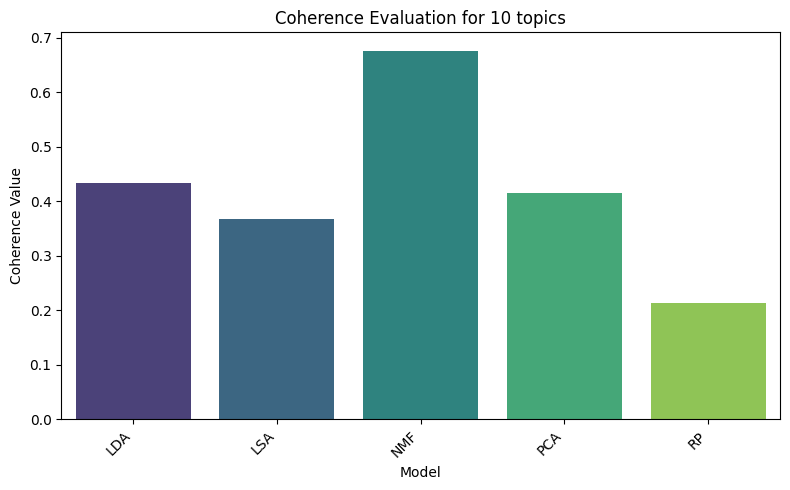

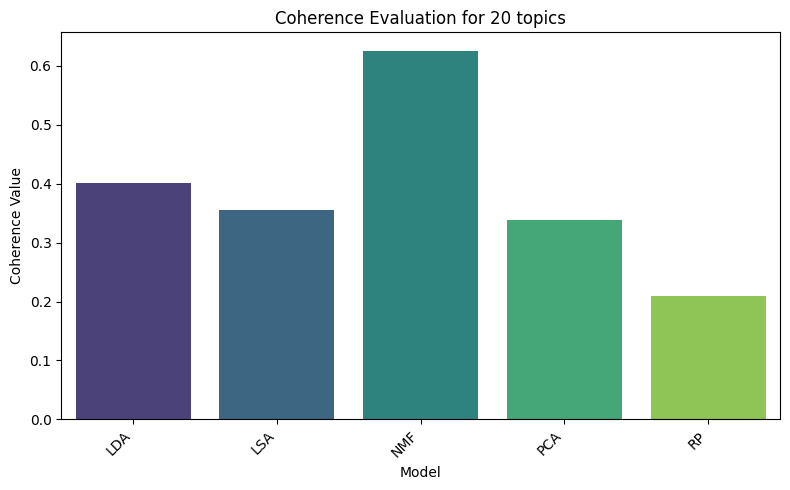

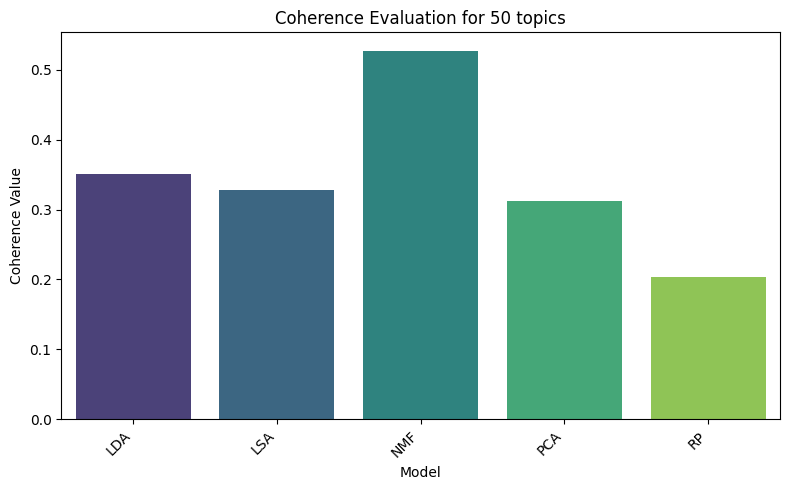

In [32]:
plots(evaluation_by_topics, 'topics')

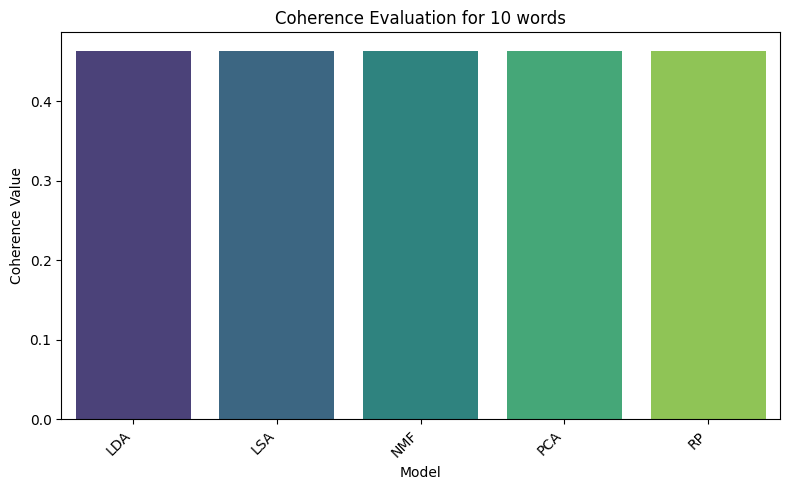

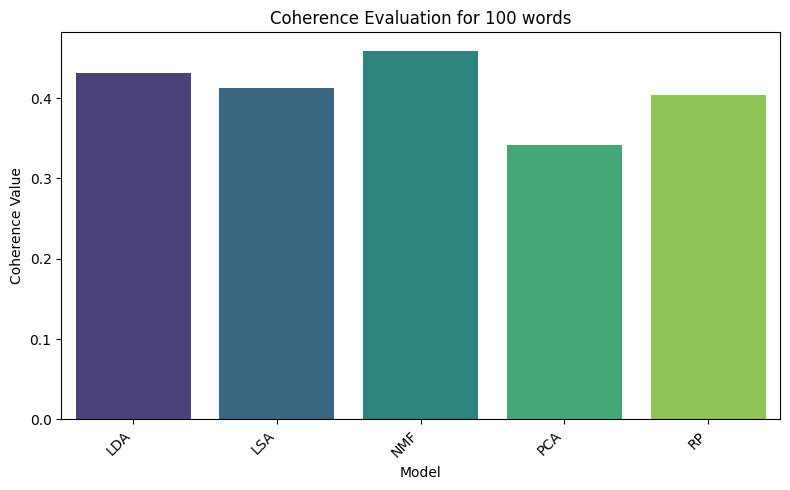

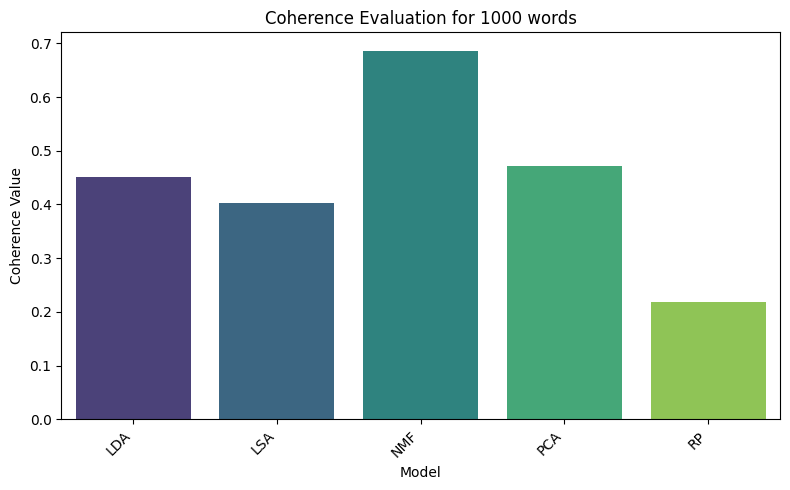

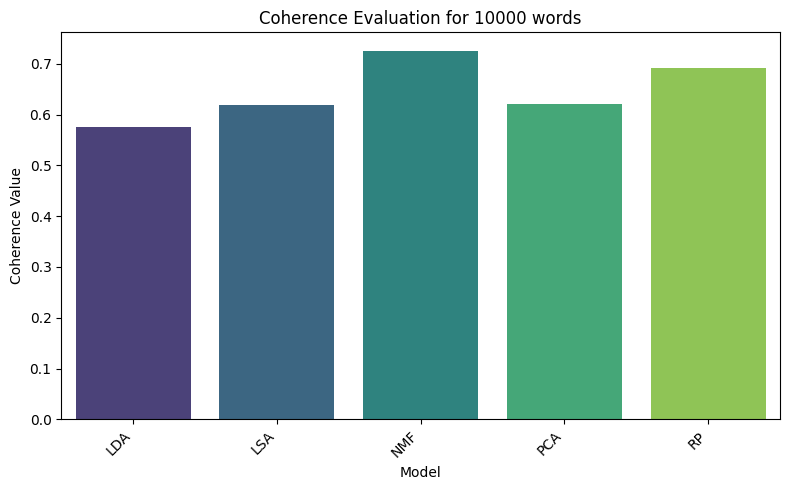

In [33]:
plots(evaluation_by_words, 'words')

In [34]:
from display_topics import display_topics

Now we'll fit the LDA model with the number of topics that yields the highest coherence

In [5]:
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5,
                     alpha='symmetric', eta='auto', passes=5, random_state=1)

In [6]:
display_topics('LDA', lda_model, feature_names)

Topic 1: email, window, system, file, program, drive, distribution, computer, work, version, card, help, sale, problem, usa
Topic 2: israel, israeli, jew, game, team, arab, jewish, player, year, play, win, hockey, fan, soldier, season
Topic 3: government, gun, state, law, clinton, president, drug, child, american, kill, tax, weapon, year, public, country
Topic 4: armenian, turkish, armenia, turk, greek, turkey, russian, los, gary, angeles, muslim, ca, nasa, april, orbit
Topic 5: god, christian, jesus, believe, church, life, bible, mean, year, point, work, writes, study, religion, world


Now we're going to do the same for LSA

In [7]:
lsi_model = LsiModel(corpus, id2word=dictionary, num_topics=5, random_seed = 1)

In [8]:
display_topics('LSA', lsi_model, feature_names)

Topic 1: system, work, year, problem, distribution, window, god, computer, drive, run, file, state, car, world, help
Topic 2: window, god, file, card, driver, drive, christian, program, jesus, believe, system, email, disk, video, problem
Topic 3: game, team, god, player, win, play, year, season, hockey, christian, jesus, baseball, score, fan, file
Topic 4: window, god, file, key, chip, car, game, clipper, encryption, government, team, christian, jesus, win, program
Topic 5: drive, key, car, file, chip, clipper, encryption, window, god, card, scsi, sale, government, program, hard


In [9]:
nmf_model = NMF(n_components=5, random_state=1).fit(tfidf_matrix)

In [10]:
display_topics('NMF', nmf_model, feature_names)

Topic 1: key, government, state, car, year, gun, chip, distribution, system, law, work, writes, space, clipper, post
Topic 2: window, file, program, run, version, help, problem, application, image, graphic, email, driver, server, manager, display
Topic 3: game, team, win, player, play, year, season, hockey, score, baseball, fan, nhl, league, playoff, run
Topic 4: god, christian, jesus, believe, bible, christ, faith, church, atheist, life, religion, belief, truth, sin, christianity
Topic 5: drive, card, sale, scsi, mb, disk, driver, monitor, mac, video, system, problem, hard, controller, work


In [11]:
tfidf_matrix_dense = tfidf_matrix.todense() if sparse.issparse(tfidf_matrix) else tfidf_matrix

# Convert to numpy array
tfidf_matrix_array = np.asarray(tfidf_matrix_dense)

# Centering
mean_tfidf = np.mean(tfidf_matrix_array, axis=0)  # Calculate the mean of each column
centered_tfidf_matrix = tfidf_matrix_array - mean_tfidf

pca_model = PCA(n_components=5, random_state=1).fit(centered_tfidf_matrix)

In [12]:
display_topics('PCA', pca_model, feature_names)

Topic 1: god, christian, jesus, believe, year, law, bible, team, life, jew, church, game, religion, christ, faith
Topic 2: game, team, player, win, play, year, season, hockey, score, baseball, fan, nhl, playoff, league, toronto
Topic 3: window, god, file, game, team, jesus, christian, win, program, bible, run, driver, player, play, version
Topic 4: key, file, chip, window, clipper, encryption, government, program, algorithm, team, public, security, game, phone, secret
Topic 5: key, god, chip, game, card, drive, clipper, scsi, encryption, system, team, mb, jesus, disk, bit


In [13]:
rp_model = GaussianRandomProjection(n_components=5, random_state=1).fit(tfidf_matrix)

In [14]:
display_topics('RP', rp_model, feature_names)

Topic 1: money, record, extra, company, president, defense, stephanopoulos, similar, st, commit, class, atheist, gm, health, appear
Topic 2: package, department, flame, happy, america, human, possible, available, chance, crime, request, woman, private, image, sense
Topic 3: hard, size, situation, detail, reference, determine, certain, die, reach, scsi, cheap, launch, bit, research, end
Topic 4: apple, tim, sometimes, tin, switch, woman, eye, inside, van, figure, child, suspect, agree, men, village
Topic 5: building, help, definition, na, moon, range, mention, shoot, describe, complete, date, happen, david, follow, youve
